In [1]:
import numpy as np
import keras.backend as K
import matplotlib.pyplot as plt

from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.normalization import BatchNormalization
from keras.layers.core import Dense, Reshape, Flatten, Activation
from keras.layers import Input
from keras.models import Model
from keras.optimizers import Adam

from keras.datasets import mnist

Using TensorFlow backend.


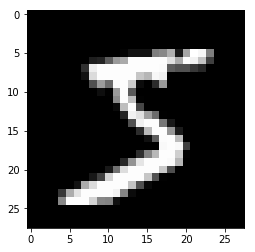

In [2]:
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()
X_train = X_train.astype(np.float32)
X_test = X_test.astype(np.float32)
X_train /= 255
X_test /= 255
plt.imshow(X_train[0], 'gray')
plt.show()

In [3]:
X_train = X_train.reshape((-1,28,28,1))
X_test = X_test.reshape((-1,28,28,1))

In [4]:
def generator_model(input_shape, train=True):
    inputs = Input(shape=(input_shape,))
    model = Dense(units=128*7*7)(inputs)
    model = Reshape((7, 7, 128), input_shape=(128*7*7,))(model)
    model = BatchNormalization()(model, training=train)
    model = Activation('relu')(model)

    model = Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same')(model)
    model = BatchNormalization()(model, training=train)
    model = Activation('relu')(model)
    model = Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same')(model)
    model = Activation('sigmoid')(model)
    
    return Model(inputs=inputs, outputs=model)

def discriminator_model(n_rows, n_cols, channels, train=True):
    inputs = Input(shape=(n_rows, n_cols, channels))
    model = Conv2D(64, (5, 5), strides=(2, 2), padding='same')(inputs)
    model = BatchNormalization()(model, training=train)
    model = Activation('relu')(model)
    model = Conv2D(128, (5, 5), strides=(2, 2), padding='same')(model)
    model = BatchNormalization()(model, training=train)
    model = Activation('relu')(model)
    model = Flatten()(model)
    model = Dense(1)(model)
    
    return Model(inputs=inputs, outputs=model)

In [5]:
# Train models
g = generator_model(100, train=True)
g.summary()
d = discriminator_model(28,28,1, train=True)
d.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 6272)              633472    
_________________________________________________________________
reshape_1 (Reshape)          (None, 7, 7, 128)         0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 7, 7, 128)         512       
_________________________________________________________________
activation_1 (Activation)    (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 14, 14, 64)        204864    
_________________________________________________________________
batch_normalization_2 (Batch (None, 14, 14, 64)        256       
__________

In [7]:
lr = 1e-4

clip_updates = [K.update(v, K.clip(v, -0.01, 0.01)) for v in d.trainable_weights]
d_clip = K.function([],[], clip_updates)

X_g = Input(shape=(100,))
X_d = Input(shape=(28, 28, 1))

d_real = d(X_d)
d_fake = d(g(X_g))

loss_d = K.mean(d_fake) - K.mean(d_real)
loss_g = -K.mean(d_fake)

opt_d = Adam(lr=lr).get_updates(loss=loss_d, params=d.trainable_weights, constraints=[])
train_d = K.function([X_d, X_g], [loss_d], opt_d)
opt_g = Adam(lr=lr).get_updates(loss=loss_g, params=g.trainable_weights, constraints=[])
train_g = K.function([X_g], [loss_g], opt_g)

In [9]:
#Train
batch_size = 64
epochs = 1

g_losses = []
d_losses = []
for ep in range(epochs):
    for l in range(X_train.shape[0]//batch_size):
        if (l+1)%100==0:
            print(l)
        noise_input = np.random.rand(batch_size, 100)
        start = l * batch_size
        end = (l + 1) * batch_size
        for _ in range(5):
            d_clip([])
            dLoss = train_d([X_train[start:end], noise_input])
        gLoss = train_g([noise_input])
        g_losses += [gLoss]
        d_losses += [dLoss]

99
199
299
399
499
599
699
799
899


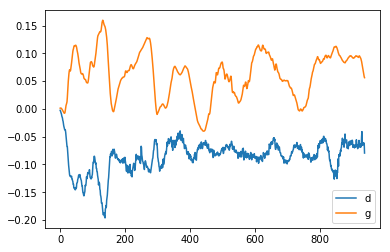

In [10]:
plt.plot(d_losses, label='d')
plt.plot(g_losses, label='g')
plt.legend()
plt.show()

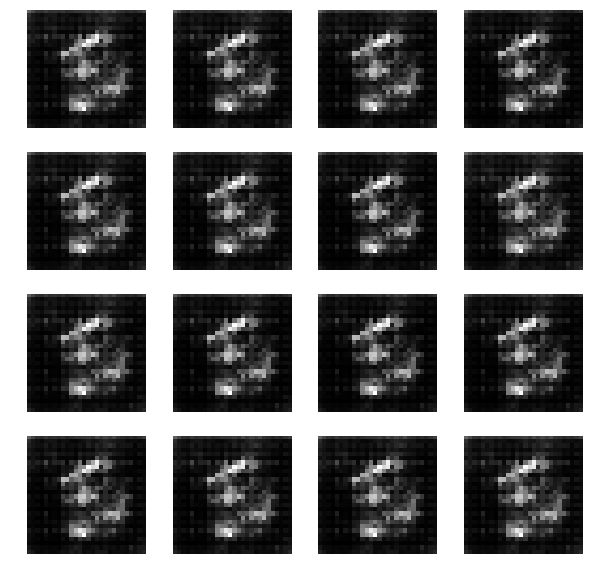

In [11]:
noise_input = np.random.rand(20, 100)
fake_images = g.predict(noise_input)

plt.figure(figsize=(10,10))
for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(fake_images[i, :, :, 0], cmap='gray')
    plt.axis('off')
plt.show()